# Exercise Book 5

**Covering the materials of Chapters 12-14.**  
Topics: graph algorithms and spatial indexing

In the attached `data` folder the following shapefiles are available for this assignment
 - `osm_roads_hungary.shp`, containing the road network of Hungary as linestrings. (Data source: [*OpenStreetMap*](https://download.geofabrik.de/europe/hungary.html))
 - `hungary_cities.shp`, containing the Hungarian cities as points. (Data source: *ELTE FI, Department of Cartography and Geoinformatics*)
 
The `osm_roads_hungary.shp` file is in *WGS 84 (EPSG:4326)* coordinate reference system. The projection of the `hungary_cities.shp` file is not defined, but the data is in *EOV (EPSG:23700)*, which you have to set it manually.

---

## Task 1

Read the input data from the Shapefiles.  
Display the cities and the road network on a map using the *matplotlib* library. (Roads shall be colored black and cities shall be red dots.)

Among the roads filter only the more significant types. **In all the following tasks you will only have to work with these type of roads.**  
More significant type of roads are where the `fclass` column of the *GeoDataFrame* is among the following values:  
`motorway`, `primary`, `secondary`, `tertiary`, `motorway_link`, `primary_link`, `secondary_link`, `tertiary_link`.

*Hint: reproject the roads to EOV before displaying the GeoDataFrame*.

In [1]:
import geopandas as gpd

# Read the shapefiles
roads = gpd.read_file('../data/osm_roads_hungary.shp')
cities = gpd.read_file('../data/hungary_cities.shp')

# Set the CRS to EOV projection (EPSG:23700) if None for cities
if cities.crs == None:
    cities.set_crs('epsg:23700', inplace=True)

# Display road types
print(roads['fclass'].unique())

['residential' 'secondary' 'primary' 'tertiary' 'service' 'unclassified'
 'footway' 'primary_link' 'track' 'pedestrian' 'steps' 'secondary_link'
 'path' 'cycleway' 'motorway_link' 'motorway' 'tertiary_link' 'trunk_link'
 'living_street' 'track_grade2' 'trunk' 'track_grade4' 'track_grade1'
 'track_grade5' 'track_grade3' 'bridleway' 'unknown']


In [2]:
# Filter roads by their type
roads = roads[roads['fclass'].isin(['motorway', 'primary', 'secondary', 'tertiary', 
                                    'motorway_link', 'primary_link', 'secondary_link', 'tertiary_link'])]

In [3]:
print("Cities CRS: {0}, Roads CRS: {1}".format(cities.crs, roads.crs))

# Convert CRS to EOV
if cities.crs != 'epsg:23700':
    cities.to_crs('epsg:23700', inplace=True)
    
if roads.crs != 'epsg:23700':
    roads.to_crs('epsg:23700', inplace=True)

print("Cities CRS: {0}, Roads CRS: {1}".format(cities.crs, roads.crs))

Cities CRS: epsg:23700, Roads CRS: epsg:4326
Cities CRS: epsg:23700, Roads CRS: epsg:23700


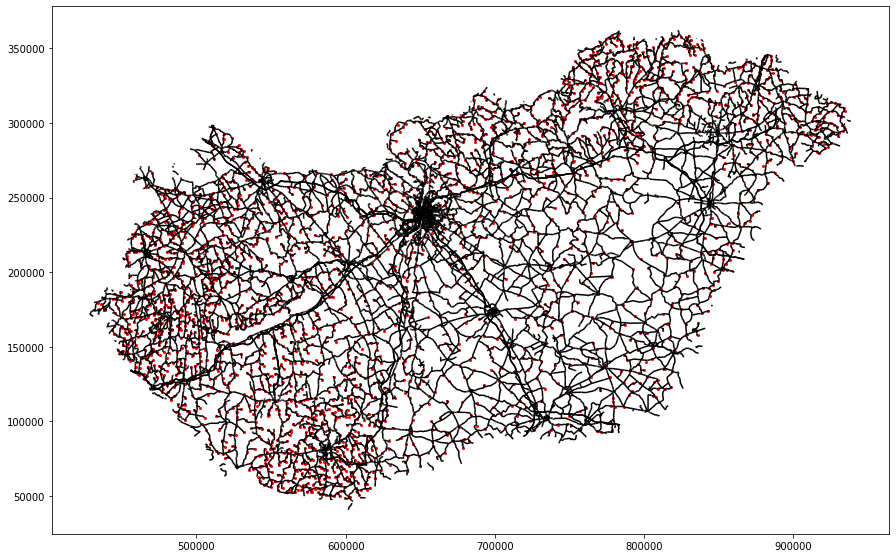

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot roads and cities
base = roads.plot(figsize=[15,10], color='black')
cities.plot(ax=base, color='red', markersize=4)

# Display plot
plt.show()

## Task 2

Display the road network of Hungary, but with a different coloring based on their class:
 - motorways should be red;
 - primary roads should be black;
 - secondary roads should be gray;
 - tertiary roads should be green.

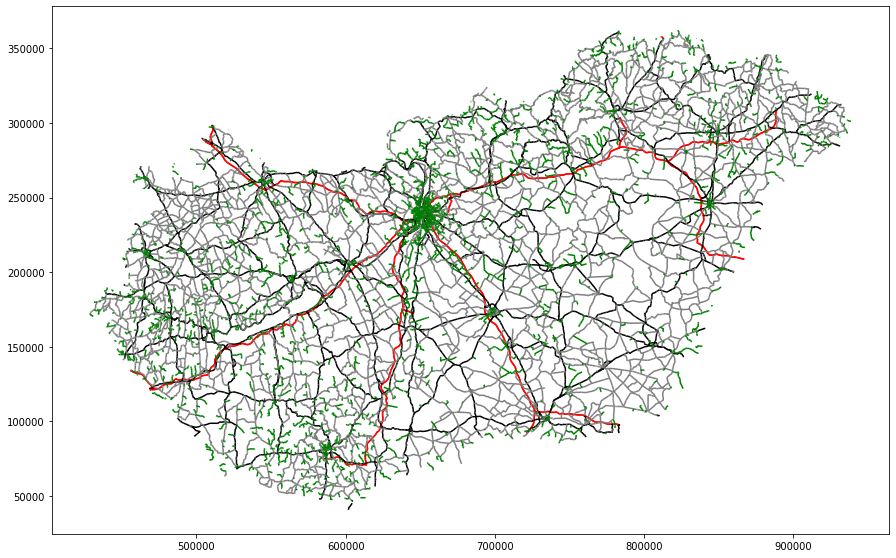

In [5]:
base = roads[roads['fclass'].isin(['motorway', 'motorway_link'])].plot(figsize=[15,10], color='red')
roads[roads['fclass'].isin(['primary', 'primary_link'])].plot(ax=base, color='black')
roads[roads['fclass'].isin(['secondary', 'seondary_link'])].plot(ax=base, color='gray')
roads[roads['fclass'].isin(['tertiary', 'tertiary_link'])].plot(ax=base, color='green')

# Display plot
plt.show()

## Task 3

Build a graph of the road network and compute the shorthest path (based on distance) between Győr and Debrecen.  
Display the complete road network (with black color) on a map and overlay the found shorthest path wirh red color.

Pairs of EOV X and Y coordinates of the cities are given below, which shall be precisely on the roads. 
* Győr: (261414.51778597923, 544944.4764306903)
* Debrecen: (247370.13702113688, 842839.3118560591)


*Hint: the coordinates in the Shapefiles are in a switched (Y, X) order.*

In [6]:
import math
import networkx as nx

# Create empty, undirected graph
graph = nx.Graph()

# Iterate through all linestrings
for idx, row in roads.iterrows():
    line = row['geometry']
    for i in range(1, len(line.coords)):
        p1 = line.coords[i-1]
        p2 = line.coords[i]
        
        # Since the file is in the EOV CRS, we can calulate the distance in SI
        # based on the Pythagoras theorem
        dist = math.sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2)) / 1000
        
        # Add it to the graph
        graph.add_edge(p1, p2, distance = dist, road_class = row['fclass'])

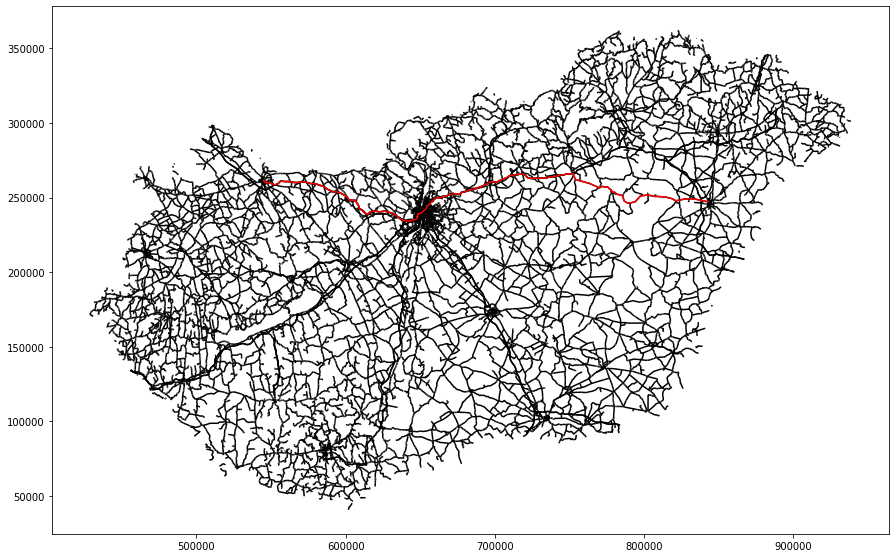

In [7]:
# Given positions
pos_gyor = (544944.4764306903, 261414.51778597923)
pos_debrecen = (842839.3118560591, 247370.13702113688)

# Calculate the shortest distance between Berlin and Budapest
path = nx.shortest_path(graph, pos_gyor, pos_debrecen, weight = 'distance')

# Draw roads
roads.plot(figsize=[15,10], color='black')

# Draw path function
def draw_path(path):
    # Get the X an Y positions into separate lists for the shortest path
    xs = [coord[0] for coord in path]
    ys = [coord[1] for coord in path]
    # Add it to the plot
    plt.plot(xs, ys, color='red')

# Draw path
draw_path(path)

# Display plot
plt.show() 

**Alternative approach:** draw the graph with *networkx*

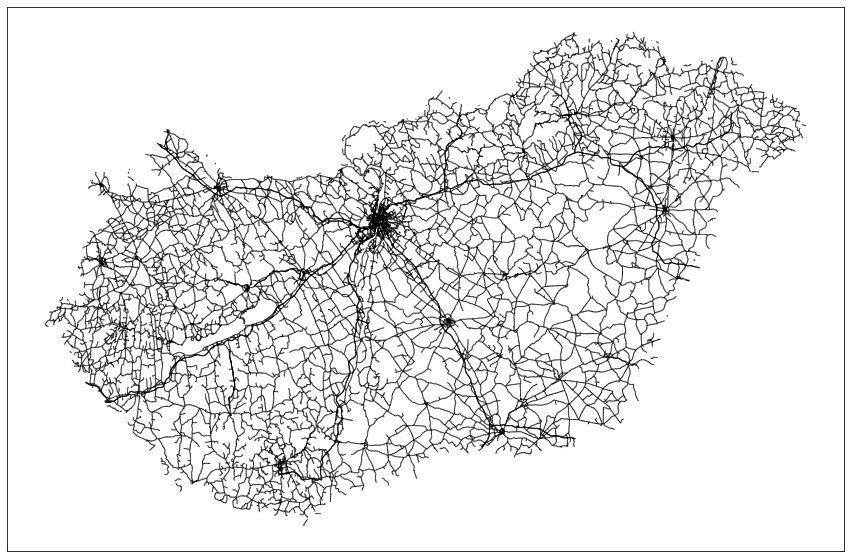

In [8]:
# Add the position to the nodes as attributes
for idx, row in roads.iterrows():
    line = row['geometry']
    for i in range(len(line.coords)):
        p = line.coords[i]
        graph.nodes[p]['position'] = p

# Draw the graph
plt.figure(figsize=[15,10])
nx.draw_networkx(graph, nx.get_node_attributes(graph, 'position'), with_labels=False, node_size=0)
plt.show()

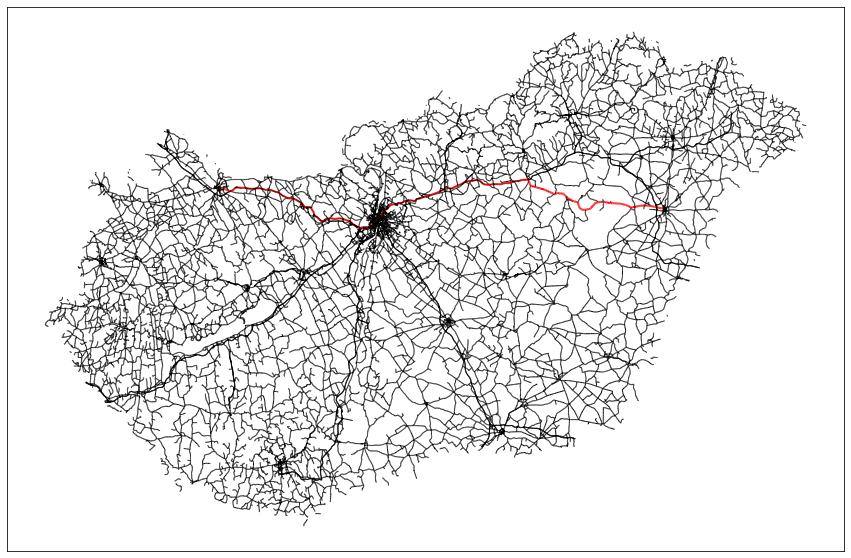

In [9]:
# Add default color and width attributes to all edges
for source, target in graph.edges:
    graph[source][target]['color'] = 'black'
    graph[source][target]['width'] = 1.0

# Modify the color and width attributes for the edges on the shorthest path
for i in range(1, len(path)):
    source = path[i-1]
    target = path[i]
    graph[source][target]['color'] = 'red'
    graph[source][target]['width'] = 2.0

# Compute list of edge colors and widths
edge_color_list = [graph[source][target]['color'] for source, target in graph.edges]
edge_width_list = [graph[source][target]['width'] for source, target in graph.edges]

# Draw the graph
plt.figure(figsize=[15,10])
nx.draw_networkx(graph, nx.get_node_attributes(graph, 'position'), with_labels=False, node_size=0, 
                 edge_color = edge_color_list, width = edge_width_list)
plt.show()

## Task 4

Let the user define the start and target coordinates for the shorthest path search. (Input validation is not required.)  
Since the user given coordinates are not necessarily on any of the roads, it is required to find the nearest vertices in the graph (both for the start and the goal).

Test data:
* Győr: (261473, 545052)
* Debrecen: (247367, 842842)

*Hint:* build a Kd-tree form the vertices of the graph.

In [10]:
import scipy.spatial # for Kd-Tree support

# Put all points on road network into list
all_points = []

for line in roads.geometry:
    for coord in line.coords:
        all_points.append(coord)

all_points = list(set(all_points))

# Build a Kd-tree
kdtree = scipy.spatial.KDTree(all_points)    

Start X coordinate:  261473
Start Y coordinate:  545052
Target X coordinate:  247367
Target Y coordinate:  842842


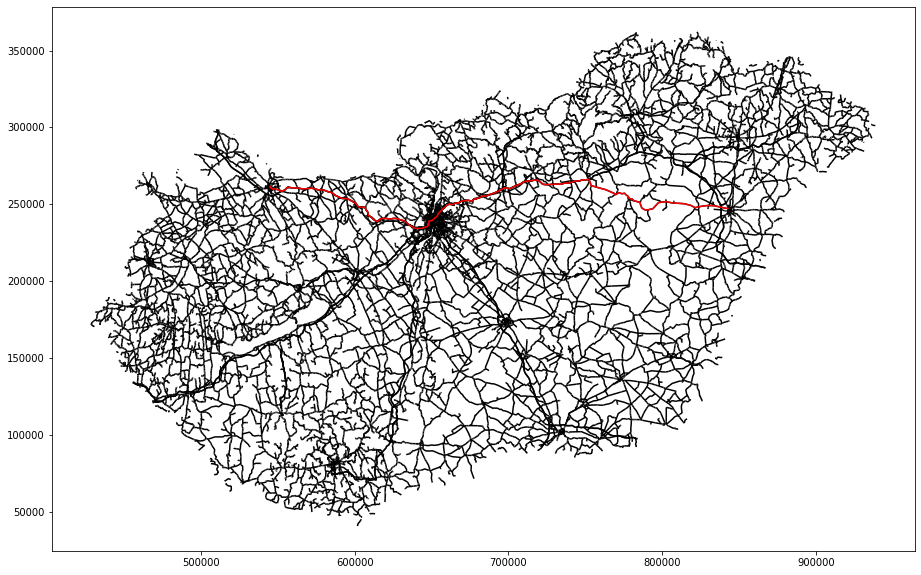

In [13]:
# Read user input
from_x = float(input('Start X coordinate: '))
from_y = float(input('Start Y coordinate: '))
to_x = float(input('Target X coordinate: '))
to_y = float(input('Target Y coordinate: '))

def closest_point(point):
    dist, idx = kdtree.query(point)
    return all_points[idx]

# Find closest points in road network
from_point = closest_point((from_y, from_x))
to_point = closest_point((to_y, to_x))

# Calculate the shortest distance between the given coordinates
path = nx.shortest_path(graph, from_point, to_point, weight = 'distance')

# Draw roads
roads.plot(figsize=[20, 10], color='black')

# Draw path
draw_path(path)

# Display plot
plt.show()

## Task 5

Let the user define the name of the start and the target city instead of coordinates.  
The Hungarian cities and their location is given in the `hungary_cities.shp` Shapefile. (These locations marks the centorid of the cities are not necessarily on any of the roads.)

Validate the user input whether the given cities exist. Show an error message if not.

In [14]:
# Set index in cities GeoDataFrame
cities.set_index('City', inplace=True)
display(cities)

,Id,County,Status,KSH,geometry
City,,,,,
Aba,1,FEJÉR,town,17376,POINT (610046.800 187639.000)
Abaliget,2,BARANYA,town,12548,POINT (577946.100 89280.800)
Abasár,3,HEVES,town,24554,POINT (721963.700 273880.300)
Abaújalpár,4,BORSOD-ABAUJ-ZEMPLÉN,town,15662,POINT (812129.200 331508.200)
Abaújkér,5,BORSOD-ABAUJ-ZEMPLÉN,town,26718,POINT (809795.600 331138.300)
...,...,...,...,...,...
Zsira,3143,GYÕR-MOSON-SOPRON,town,04622,POINT (471324.200 237577.200)
Zsombó,3144,CSONGRÁD,town,17765,POINT (721098.100 109690.000)
Zsujta,3145,BORSOD-ABAUJ-ZEMPLÉN,town,11022,POINT (815027.400 353143.100)


Start city:  Budapest
Target city:  Békéscsaba


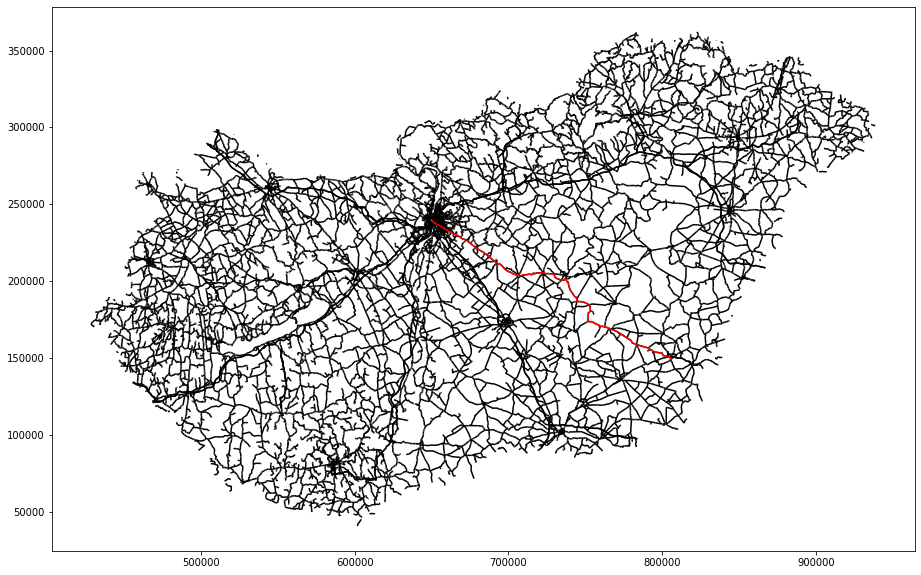

In [15]:
# Read user input
from_city = input('Start city: ')
to_city = input('Target city: ')

# Check whether the given cities exist in the dataset
if from_city in cities.index and to_city in cities.index:
    # Find coordinates for cities
    from_x = cities.loc[from_city].geometry.y
    from_y = cities.loc[from_city].geometry.x
    to_x = cities.loc[to_city].geometry.y
    to_y = cities.loc[to_city].geometry.x
    
    # Find closest points in road network
    from_point = closest_point((from_y, from_x))
    to_point = closest_point((to_y, to_x))
    
    # Calculate the shortest distance between the given cities
    path = nx.shortest_path(graph, from_point, to_point, weight = 'distance')
    
    # Draw roads
    roads.plot(figsize=[20, 10], color='black')

    # Draw path
    draw_path(path)

    # Display plot
    plt.show()
else:
    print('Start or target city not found!')

## Task 6

Instead of calculating the shortest path based on geographical distance between two user given cities, calculate the shorthest path based on the travel time!
Let's define the following speed limits for the various classes of roads:
 - motorway: 130 km/h
 - primary road: 90 km/h
 - secondary road: 70 km/h (since their condition is degraded)
 - tertiary road: 50 km/h

We assume the that user an drive with the speed limit on all roads.

Test data: the Budapest - Békéscsaba path should be different when the shortest path based on geographical distance between and shortest path based on travel time is calculated.

Start city:  Budapest
Target city:  Békéscsaba


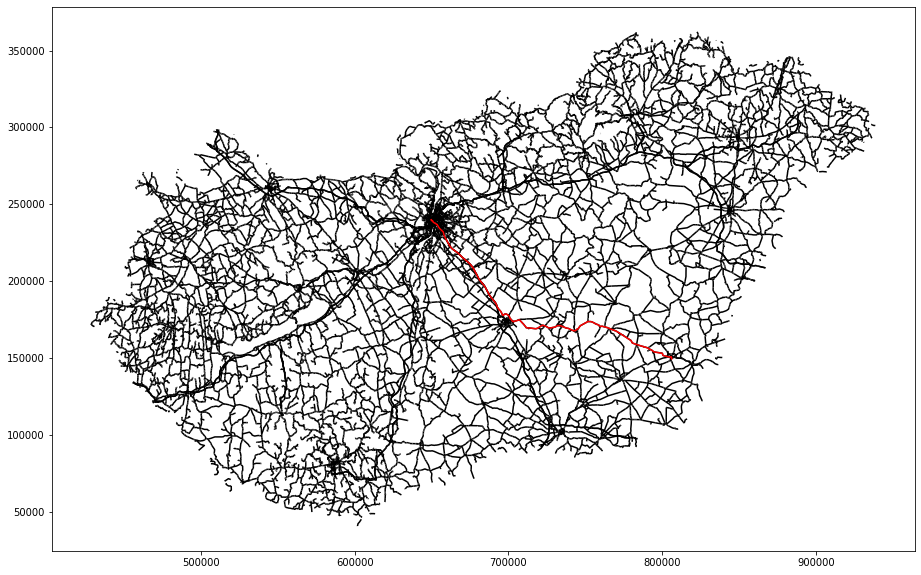

In [16]:
def custom_distance(from_node, to_node, edge_attr):
    speed_limit = 50
    if edge_attr['road_class'] in ['motorway', 'motorway_link']:
        speed_limit = 130
    if edge_attr['road_class'] in ['primary', 'primary_link']:
        speed_limit = 90
    if edge_attr['road_class'] in ['secondary', 'secondary_link']:
        speed_limit = 70
    return edge_attr['distance'] / speed_limit

# Read user input
from_city = input('Start city: ')
to_city = input('Target city: ')

# Check whether the given cities exist in the dataset
if from_city in cities.index and to_city in cities.index:
    # Find coordinates for cities
    from_x = cities.loc[from_city].geometry.y
    from_y = cities.loc[from_city].geometry.x
    to_x = cities.loc[to_city].geometry.y
    to_y = cities.loc[to_city].geometry.x
    
    # Find closest points in road network
    from_point = closest_point((from_y, from_x))
    to_point = closest_point((to_y, to_x))
    
    # Calculate the shortest distance  between the given cities
    path = nx.shortest_path(graph, from_point, to_point, weight = custom_distance)
    
    # Draw roads
    roads.plot(figsize=[20, 10], color='black')

    # Draw path
    draw_path(path)

    # Display plot
    plt.show()
else:
    print('Start or target city not found!')